# Resolving layers

Let's revisit the steady advection-diffusion equation

$$
\partial_x u - \lambda \partial_{xx} u = 0
$$

subject to $u(-1)=1$, $u(1)=-1$.

In [1]:
include("diffmats.jl")
function advdiff(λ,n)
    a,b = -1,1
    h = (b-a)/n
    x = [a+i*h for i in 0:n]
    Dx,Dxx = diffmats(x)
    Ã = Dx - λ*Dxx
    A = diagm(ones(n+1))
    A[2:n,:] .= Ã[2:n,:]
    f = [1; zeros(n-1); -1]
    return x,A\f 
end

advdiff (generic function with 1 method)

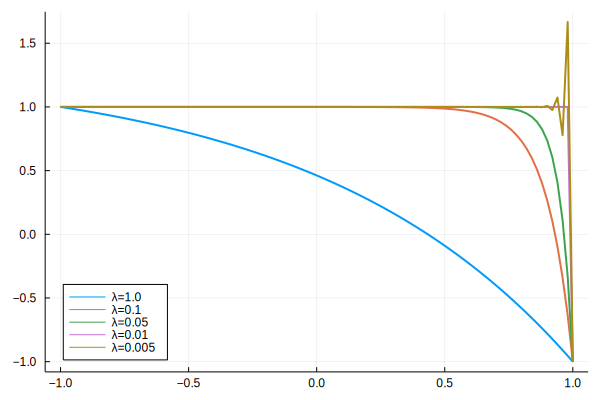

In [2]:
using Plots
plt = plot(legend=:bottomleft)
for λ in [1,0.1,0.05,0.01,0.005]
    x,u = advdiff(λ,100)
    plot!(x,u,label="λ=$λ")
end
plt

Note that the limit $\lambda=0$ is singular, in the sense that the order of the ODE drops and we can no longer satisfy the conditions at both ends. (By contrast, $1/\lambda \to 0$ is just fine.) Physically, as diffusion weakens relative to the advection from left to right, nearly all the material gets pushed up against the right boundary, creating a **boundary layer**. The same phenomenon can occur interior to the region, and it appears in both linear and nonlinear problems.

In the last case above, the FD method is unable to give a decent answer due to the large gradient at the right. You could think of this in terms of high-wavenumber content that the grid doesn't resolve well enough. We could fix the problem by cranking up $n$, but this is a losing proposition in the long run: you increase the resolution everywhere in order to deal with a highly localized phenomenon.

It would be far better to crowd more points into the layer and have fewer where the solution changes slowly. We could add nodes in an ad-hoc manner and still create differentiation matrices using Fornberg's algorithm, but it's considered preferable to have a smoothly changing node density where possible.

## Change of coordinate

Let's introduce a change of coordinate using a monotonic function $\xi(s)$ such that $\xi(\pm 1)=\pm 1$. We want $\xi$ to increase very slowly as its value gets close to $1$. Here is a function that has the right sort of shape:

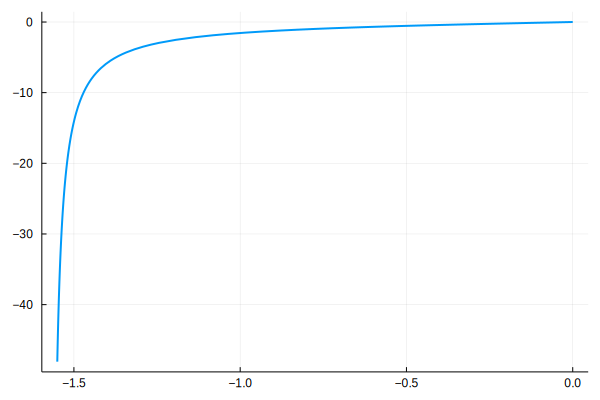

In [3]:
plot(tan,-1.55,0)

Here's how we adapt this shape to our needs:

1. Map $[-1,1]$ to $[-\gamma,0]$ where $\tan(\gamma)=M$ for some large $M$: $s_1=\frac{1}{2}\gamma(s-1)$ 
2. Take $s_2=\tan(s_1)$, mapping to $[-M,0]$.
3. Map $[-M,0]$ to $[-1,1]$: $x = 1 + \frac{2}{M}s_2$.

The value of $M$ controls how steep the curve is at the left end, and in turn the amount of compression in the nodes on the right end.

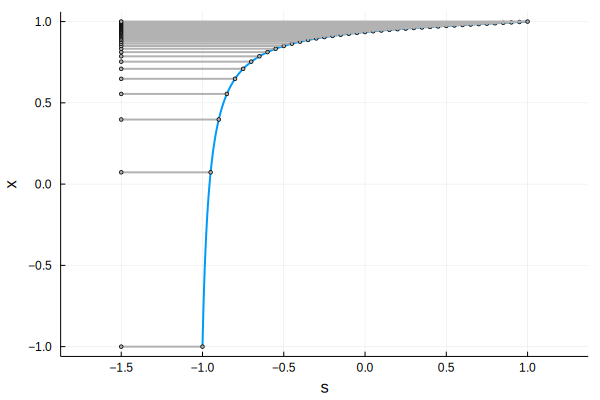

In [4]:
M = 30
γ = atan(M)
ξ(s) = 1 + 2/M*tan(γ*(s-1)/2)
plot(ξ,-1,1,aspect_ratio=1,xlabel="s",ylabel="x")

s = range(-1,1,41)
x = ξ.(s)
plot!([-1.5ones(41) s]',[x x]',color=Gray(0.7),m=2)

Now we solve the problem as a function of $s$. By the chain rule, 

$$
\partial_x &= \frac{1}{\xi'(s)}\partial_s, \\
\partial_{xx} &= \frac{1}{\xi'(s)^2}\partial_{ss} - \frac{\xi''(s)}{\xi'(s)^2}\partial_s
$$

These require just diagonal matrices left-multiplying the usual DMs $D_s$, $D_{ss}$.

In [5]:
function advdiff(λ,M,n)
    a,b = -1,1
    h = (b-a)/n
    s = [a+i*h for i in 0:n]
    γ = atan(M)
    s₁ = @. γ*(s-1)/2
    x = @. 1 + 2/M*tan(s₁)
    Ds,Dss = diffmats(s)
    ξ₁ = @. (γ/M)*sec(s₁)^2
    ξ₂ = @. (γ^2/M)*sec(s₁)^2*tan(s₁)
    Dx = diagm(@. 1/ξ₁)*Ds 
    Dxx = diagm(@. 1/(ξ₁)^2)*Dss - diagm(@. ξ₂/(ξ₁)^3)*Ds

    Ã = Dx - λ*Dxx
    A = diagm(ones(n+1))
    A[2:n,:] .= Ã[2:n,:]
    f = [1; zeros(n-1); -1]
    return s,x,A\f 
end

advdiff (generic function with 2 methods)

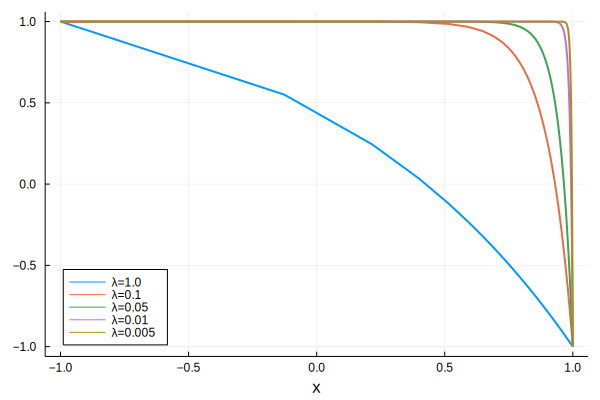

In [6]:
plt = plot(legend=:bottomleft)
for λ in [1,0.1,0.05,0.01,0.005]
    s,x,u = advdiff(λ,50,100)
    plot!(x,u,label="λ=$λ",xlabel="x")
end
plt

The mapped method is not so good for the uniform case now, because we put the nodes in the wrong location. Looking at the solutions over the computational domain better reveals what has happened.

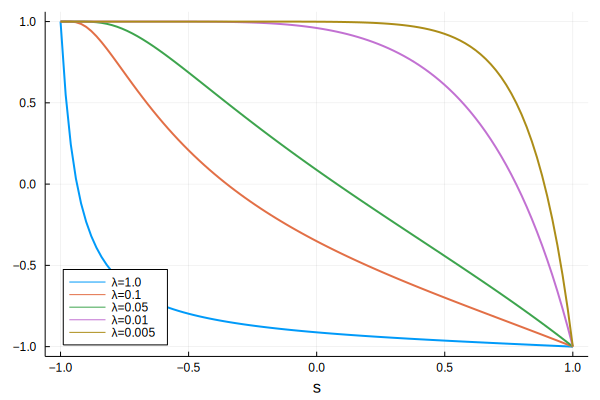

In [7]:
plt = plot(legend=:bottomleft)
for λ in [1,0.1,0.05,0.01,0.005]
    s,x,u = advdiff(λ,50,100)
    plot!(s,u,label="λ=$λ",xlabel="s")
end
plt

The $M$ we chose works very well for the 0.1 and 0.05 cases, is too large for 1.0, and is smaller than ideal for the smallest $\lambda$ values. There are adaptive methods that try to choose $M$ well automatically, or to automate the entire coordinate transformation (**moving-mesh** methods), but that's going far afield for us.